In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pandas as pd
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

## Initial changes

In [ ]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2019-01'),
    first_days=5,
    scale=False
#     split='train'
)

In [43]:
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train[idx]
    mean_precip.append(y.max())

In [44]:
mean_precip = np.array(mean_precip)

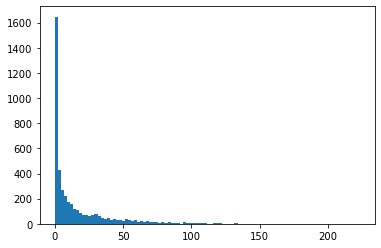

In [47]:
plt.hist(mean_precip, bins=100);
# plt.yscale('log')

In [12]:
cat_bins = np.arange(0, 102, 2, dtype='float')
cat_bins = np.append(np.insert(cat_bins, 1, 0.01), np.inf)
len(cat_bins)

53

In [13]:
cat_bins

array([0.0e+00, 1.0e-02, 2.0e+00, 4.0e+00, 6.0e+00, 8.0e+00, 1.0e+01,
       1.2e+01, 1.4e+01, 1.6e+01, 1.8e+01, 2.0e+01, 2.2e+01, 2.4e+01,
       2.6e+01, 2.8e+01, 3.0e+01, 3.2e+01, 3.4e+01, 3.6e+01, 3.8e+01,
       4.0e+01, 4.2e+01, 4.4e+01, 4.6e+01, 4.8e+01, 5.0e+01, 5.2e+01,
       5.4e+01, 5.6e+01, 5.8e+01, 6.0e+01, 6.2e+01, 6.4e+01, 6.6e+01,
       6.8e+01, 7.0e+01, 7.2e+01, 7.4e+01, 7.6e+01, 7.8e+01, 8.0e+01,
       8.2e+01, 8.4e+01, 8.6e+01, 8.8e+01, 9.0e+01, 9.2e+01, 9.4e+01,
       9.6e+01, 9.8e+01, 1.0e+02,     inf])

In [71]:
X, y = ds_train[600]
X.shape, y.shape

((1, 16, 16), (1, 128, 128))

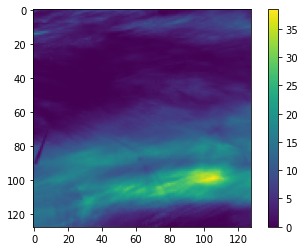

In [72]:
plt.imshow(y[0])
plt.colorbar();

In [6]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """Copied from keras source code
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [88]:
a = pd.cut(y.reshape(-1), cat_bins, labels=False, include_lowest=True).reshape(y.shape)
a.shape

(1, 128, 128)

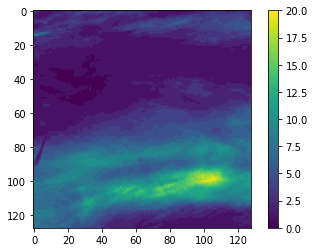

In [89]:
plt.imshow(a[0])
plt.colorbar();

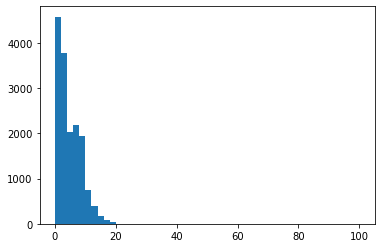

In [93]:
plt.hist(a.flat, bins=cat_bins);

In [94]:
a = to_categorical(a.squeeze(), num_classes=len(cat_bins))

In [95]:
a = np.rollaxis(a, 2)

In [96]:
a.shape

(53, 128, 128)

## Changes implemented

In [174]:
cat_bins = np.arange(0, 55, 5, dtype='float')
cat_bins = np.append(np.insert(cat_bins, 1, 0.01), np.inf)
len(cat_bins)

13

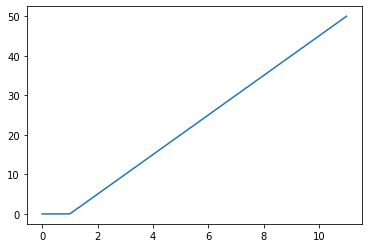

In [244]:
plt.plot(cat_bins)

In [175]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    first_days=5,
    scale=True,
    cat_bins=cat_bins
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [176]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2019-01', '2019-12'),
    first_days=2,
    scale=True,
    cat_bins=cat_bins,
    mins=ds_train.mins,
    maxs=ds_train.maxs
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [177]:
X, y = ds_train[600]
X.shape, y.shape

((1, 16, 16), (128, 128))

In [243]:
y

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 2, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 3, 3, 3],
         ...,
         [2, 2, 1,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [251]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid), replacement=True)

In [252]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [253]:
len(dl_train)

124

In [254]:
len(ds_train)

3960

In [285]:
X, y = next(iter(dl_train))

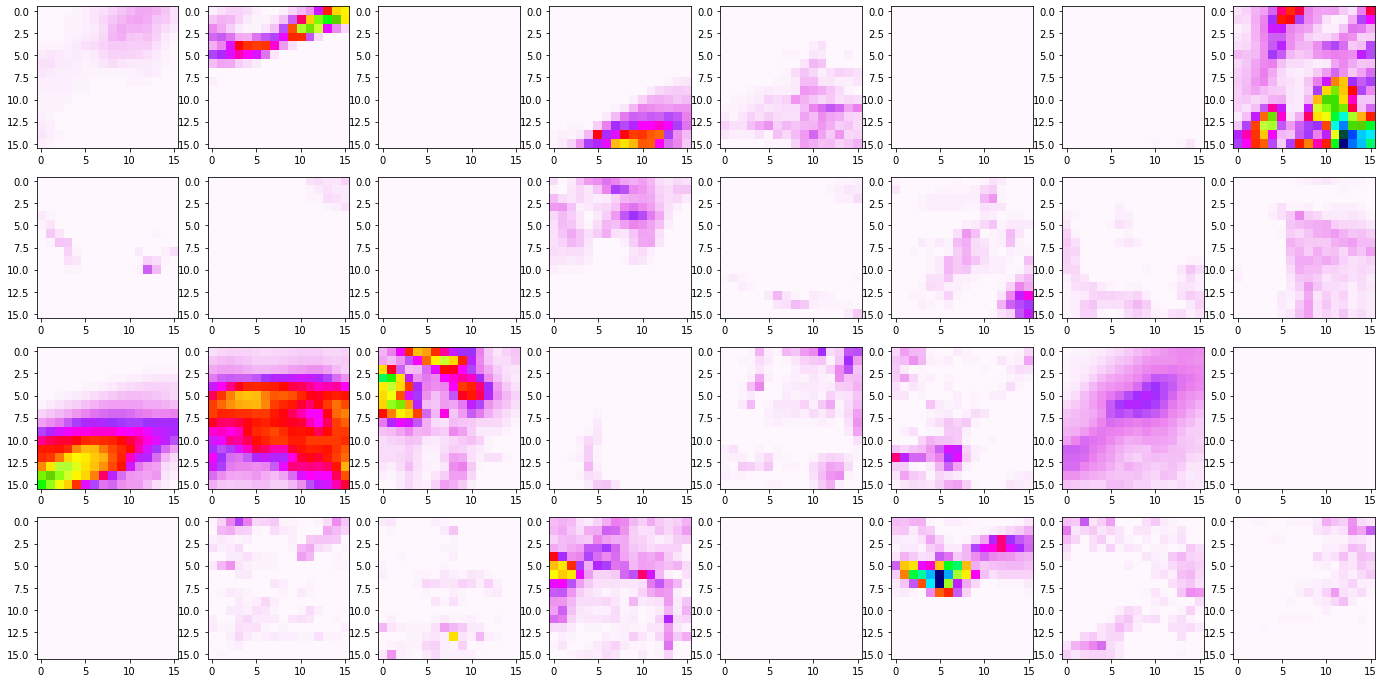

In [286]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=0.5)

In [257]:
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 128, 128]))

In [258]:
y.type()

'torch.LongTensor'

In [259]:
class UpsampleBlock(nn.Module):
    def __init__(self, nf, spectral_norm=False, method='PixelShuffle'):
        super().__init__()
        self.conv = nn.Conv2d(nf, nf * 4 if method=='PixelShuffle' else nf, kernel_size=3, stride=1, padding=1)
        if method == 'PixelShuffle':
            self.upsample = nn.PixelShuffle(2)
        elif method == 'bilinear':
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            raise NotImplementedError
        self.activation = nn.LeakyReLU(0.2)
        if spectral_norm: 
            self.conv = nn.utils.spectral_norm(self.conv)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.upsample(out)
        out = self.activation(out)
        return out

In [260]:
class Generator(nn.Module):
    """Generator with noise vector and spectral normalization """
    def __init__(self, nres, nf_in, nf, relu_out=False, use_noise=True, spectral_norm=True,
                 nout=1, softmax_out=False, upsample_method='PixelShuffle'):
        """ General Generator with different options to use. e.g noise, Spectral normalization (SN) """
        super().__init__()
        self.relu_out = relu_out
        self.softmax_out = softmax_out
        self.use_noise = use_noise
        self.spectral_norm = spectral_norm

        # First convolution
        if use_noise: 
            self.conv_in = nn.Conv2d(nf_in, nf-1, kernel_size=9, stride=1, padding=4)
        else: 
            self.conv_in = nn.Conv2d(nf_in, nf, kernel_size=9, stride=1, padding=4)
        self.activation_in = nn.LeakyReLU(0.2)

        # Resblocks keeping shape
        self.resblocks = nn.Sequential(*[
            ResidualBlock(nf, spectral_norm=spectral_norm) for i in range(nres)
        ])
        # Resblocks with upscaling
        self.upblocks = nn.Sequential(*[
            UpsampleBlock(nf, spectral_norm=spectral_norm, method=upsample_method) for i in range(3)
        ])
        self.conv_out = nn.Conv2d(nf, nout, kernel_size=9, stride=1, padding=4)
        
        if spectral_norm: 
            self.conv_in = nn.utils.spectral_norm(self.conv_in)
            self.conv_out = nn.utils.spectral_norm(self.conv_out)
        
    def forward(self, x):
        out = self.conv_in(x)
        out = self.activation_in(out)
        if self.use_noise: 
            bs, _, h, w = x.shape
            z = torch.normal(0, 1, size=(bs, 1, h, w), device=device, requires_grad=True)
            out = torch.cat([out, z], dim=1)
        skip = out
        out = self.resblocks(out)
        out = out + skip
        out = self.upblocks(out)
        out = self.conv_out(out)
        if self.relu_out:
            out = nn.functional.relu(out)
        if self.softmax_out:
            out = nn.functional.softmax(out, dim=1)
        return out

In [261]:
gen = Generator(
    nres=3, nf_in=1, nf=64, relu_out=False, use_noise=False, spectral_norm=False,
    nout=len(cat_bins)-1, softmax_out=False, upsample_method='bilinear'
).to(device)

In [262]:
count_parameters(gen)

399820

In [263]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [264]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [265]:
trainer.fit(10)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


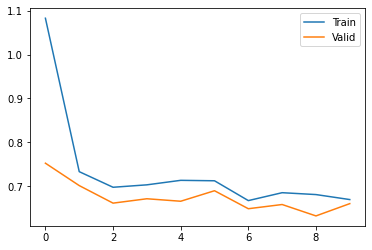

In [266]:
trainer.plot_losses()

In [289]:
preds = nn.functional.softmax(gen(X.to(device)), dim=1).cpu().detach().numpy()

In [290]:
preds.shape

(32, 12, 128, 128)

In [291]:
target = y.cpu().detach().numpy()

In [292]:
target.shape

(32, 128, 128)

In [293]:
np.argmax(target.mean((1, 2)))

7

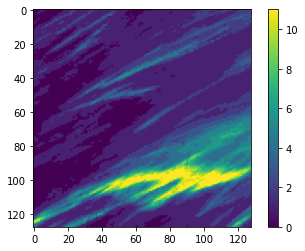

In [294]:
i=7
plt.imshow(target[i])
plt.colorbar()

In [295]:
target[i, 20, 20]

1

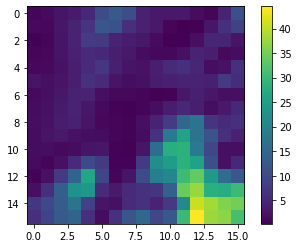

In [296]:
plt.imshow(X[i, 0] * ds_train.maxs.tp.values)
plt.colorbar();

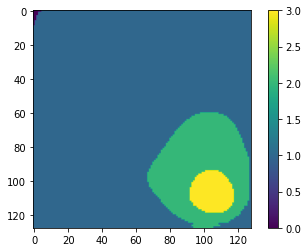

In [297]:
plt.imshow(np.argmax(preds[i], axis=0))
plt.colorbar()

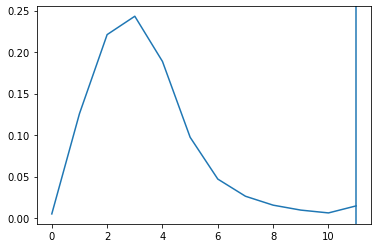

In [298]:
plt.plot(preds[i, :, 100, 100])
plt.axvline(target[i, 100, 100])

In [299]:
cdf = np.cumsum(preds, axis=1)
cdf.shape

(32, 12, 128, 128)

In [300]:
len(cat_bins)

13

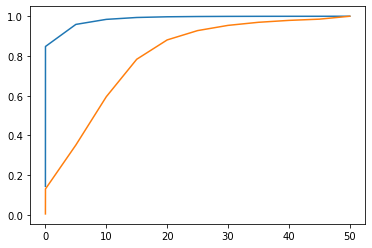

In [302]:
plt.plot(cat_bins[:-1], cdf[i, :, 20, 20])
plt.plot(cat_bins[:-1], cdf[i, :, 100, 100])

In [303]:
from scipy.ndimage import gaussian_filter
def corr_random2D(size, sigma=5, inflation=0.5):
    r = np.random.uniform(size=(size, size))
    r = gaussian_filter(r, sigma)
    r = (r - 0.5) * (inflation / r.std()) + 0.5
    r = 1/(1 + np.exp(-r))
    return r

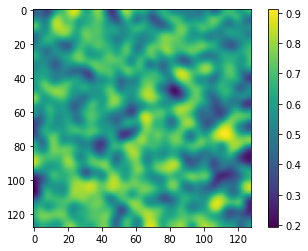

In [382]:
rand  = corr_random2D(128, 3)
plt.imshow(rand)
plt.colorbar();

In [322]:
cat_bins

array([0.0e+00, 1.0e-02, 5.0e+00, 1.0e+01, 1.5e+01, 2.0e+01, 2.5e+01,
       3.0e+01, 3.5e+01, 4.0e+01, 4.5e+01, 5.0e+01,     inf])

In [323]:
c = cdf[i, :, 100, 100]

In [324]:
c = np.insert(c, 0, 0)

In [325]:
c

array([0.        , 0.0049909 , 0.13074917, 0.35174093, 0.59485   ,
       0.783497  , 0.8808045 , 0.9277575 , 0.95402265, 0.96955895,
       0.97914183, 0.9853347 , 1.0000001 ], dtype=float32)

In [347]:
len(cat_bins), len(c)

(13, 13)

In [340]:
p = rand[100, 100]
p

0.6163441804724278

In [341]:
b = np.digitize(p, c, right=True) - 1
b

4

In [342]:
c[b], c[b+1]

(0.59485, 0.783497)

In [343]:
w1 = (p - c[b]) / (c[b+1] - c[b])
w2 = (c[b+1] - p) / (c[b+1] - c[b])
w1, w2

(0.1139386257027009, 0.8860613742972991)

In [344]:
v = cat_bins[b] * w1 + cat_bins[b+1] * w2
v

19.430306871486493

In [403]:
def cat2real1D(pdf, q, cat_bins, interpolate=True):
    c = np.cumsum(pdf)
    c = np.insert(c, 0, 0)
    b = np.digitize(q, c, right=True) - 1
    if interpolate:
        w1 = (q - c[b]) / (c[b+1] - c[b])
        w2 = (c[b+1] - q) / (c[b+1] - c[b])
    else: 
        w1, w2 = 0.5, 0.5
    assert w1 >0, 'Weights must be positive'
    assert w2 >0, 'Weights must be positive'
    v = cat_bins[b] * w2 + cat_bins[b+1] * w1
    return v

In [404]:
import pdb

In [405]:
def cat2real2D(pdf, q, cat_bins, interpolate=True):
    nbins, nx, ny = pdf.shape
#     pdb.set_trace()
    r = [cat2real1D(a, b, cat_bins, interpolate) for a, b in zip(pdf.reshape(nbins, -1).T, q.reshape(-1))]
    r = np.array(r).reshape(nx, ny)
    return r

In [481]:
o = cat2real2D(pdf, rand, cat_bins)

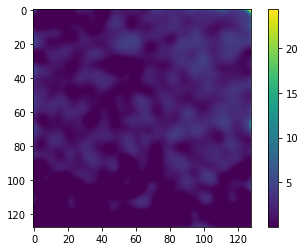

In [482]:
plt.imshow(o)
plt.colorbar();

In [450]:
weights = ds_valid.compute_weights()

In [460]:
np.argsort(weights)[::-1][:20]

array([1691, 1041,  479,  480, 1034,  482, 1031, 1030, 1029,  485,  498,
        499, 1020, 1019, 1018, 1017,  501, 1013, 1011, 1010])

In [497]:
X_sample, y_sample = ds_valid.__getitem__(501, no_cat=True)

In [498]:
X_sample.shape, y_sample.shape

((1, 16, 16), (1, 128, 128))

In [499]:
vmin=0
vmax=10

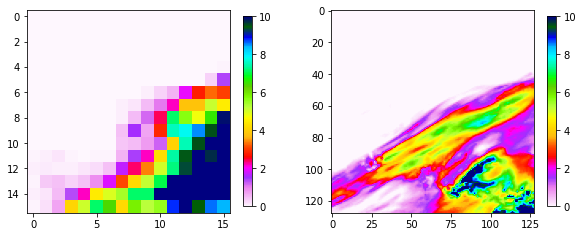

In [500]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img = ax1.imshow(X_sample[0]*ds_valid.maxs.tp.values, cmap='gist_ncar_r', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax1, shrink=0.7)
img = ax2.imshow(y_sample[0], cmap='gist_ncar_r', vmin=vmin, vmax=vmax)
plt.colorbar(img, ax=ax2, shrink=0.7)

In [501]:
pdf = nn.functional.softmax(gen(torch.from_numpy(X_sample[None]).to(device))).cpu().detach().numpy()[0]

<ipython-input-501-b128a729a8e5>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pdf = nn.functional.softmax(gen(torch.from_numpy(X_sample[None]).to(device))).cpu().detach().numpy()[0]


In [502]:
pdf.shape

(12, 128, 128)

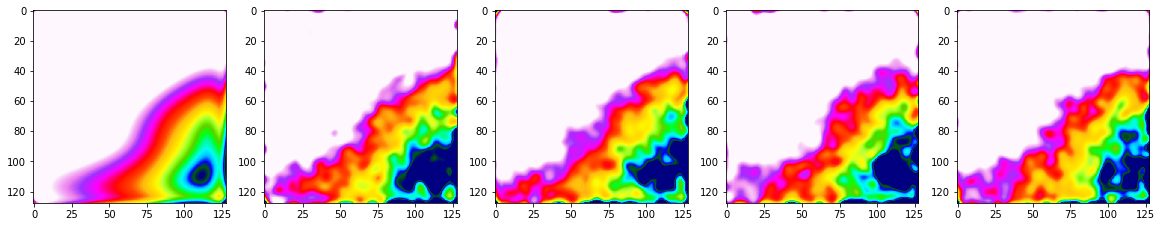

In [504]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    if i ==0:
        rand = np.ones((128, 128)) * 0.5
    else:
        rand = corr_random2D(128, 3, inflation=0.3)
    o = cat2real2D(pdf, rand, cat_bins)
    axs[i].imshow(o, cmap='gist_ncar_r', vmin=vmin, vmax=vmax)

## Overfitting test MSE

In [346]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    first_days=5,
    scale=True,
#     cat_bins=cat_bins
#     split='train'
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


KeyboardInterrupt: 

In [ ]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2019-01', '2019-12'),
    first_days=2,
    scale=True,
#     cat_bins=cat_bins,
    mins=ds_train.mins,
    maxs=ds_train.maxs
#     split='train'
)

In [ ]:
X, y = ds_train[600]
X.shape, y.shape

In [ ]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [ ]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [ ]:
len(dl_train)

In [ ]:
len(ds_train)

In [ ]:
X, y = next(iter(dl_train))

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=0.5)

In [ ]:
X.shape, y.shape

In [ ]:
y.type()

In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, nf, spectral_norm=False, method='PixelShuffle'):
        super().__init__()
        self.conv = nn.Conv2d(nf, nf * 4 if method=='PixelShuffle' else nf, kernel_size=3, stride=1, padding=1)
        if method == 'PixelShuffle':
            self.upsample = nn.PixelShuffle(2)
        elif method == 'bilinear':
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            raise NotImplementedError
        self.activation = nn.LeakyReLU(0.2)
        if spectral_norm: 
            self.conv = nn.utils.spectral_norm(self.conv)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.upsample(out)
        out = self.activation(out)
        return out

In [ ]:
class Generator(nn.Module):
    """Generator with noise vector and spectral normalization """
    def __init__(self, nres, nf_in, nf, relu_out=False, use_noise=True, spectral_norm=True,
                 nout=1, softmax_out=False, upsample_method='PixelShuffle'):
        """ General Generator with different options to use. e.g noise, Spectral normalization (SN) """
        super().__init__()
        self.relu_out = relu_out
        self.softmax_out = softmax_out
        self.use_noise = use_noise
        self.spectral_norm = spectral_norm

        # First convolution
        if use_noise: 
            self.conv_in = nn.Conv2d(nf_in, nf-1, kernel_size=9, stride=1, padding=4)
        else: 
            self.conv_in = nn.Conv2d(nf_in, nf, kernel_size=9, stride=1, padding=4)
        self.activation_in = nn.LeakyReLU(0.2)

        # Resblocks keeping shape
        self.resblocks = nn.Sequential(*[
            ResidualBlock(nf, spectral_norm=spectral_norm) for i in range(nres)
        ])
        # Resblocks with upscaling
        self.upblocks = nn.Sequential(*[
            UpsampleBlock(nf, spectral_norm=spectral_norm, method=upsample_method) for i in range(3)
        ])
        self.conv_out = nn.Conv2d(nf, nout, kernel_size=9, stride=1, padding=4)
        
        if spectral_norm: 
            self.conv_in = nn.utils.spectral_norm(self.conv_in)
            self.conv_out = nn.utils.spectral_norm(self.conv_out)
        
    def forward(self, x):
        out = self.conv_in(x)
        out = self.activation_in(out)
        if self.use_noise: 
            bs, _, h, w = x.shape
            z = torch.normal(0, 1, size=(bs, 1, h, w), device=device, requires_grad=True)
            out = torch.cat([out, z], dim=1)
        skip = out
        out = self.resblocks(out)
        out = out + skip
        out = self.upblocks(out)
        out = self.conv_out(out)
        if self.relu_out:
            out = nn.functional.relu(out)
        if self.softmax_out:
            out = nn.functional.softmax(out, dim=1)
        return out

In [ ]:
gen = Generator(
    nres=3, nf_in=1, nf=64, relu_out=False, use_noise=False, spectral_norm=False,
    nout=1, softmax_out=False, upsample_method='PixelShuffle'
).to(device)

In [ ]:
count_parameters(gen)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-5)

In [ ]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [ ]:
trainer.fit(10)

In [ ]:
trainer.plot_losses()

In [ ]:
plot_sample(X, y, gen, 13)